In [178]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pandas as pd
import emoji
import string
import spacy
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [172]:
data = pd.read_csv('data/mental_health_data.csv', index_col=0)
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [173]:
print('Число пропусков в колонке statement:', data['statement'].isna().sum())
print('Число пропусков в колонке status:', data['status'].isna().sum())
data = data.dropna().reset_index().drop(columns='index')

Число пропусков в колонке statement: 362
Число пропусков в колонке status: 0


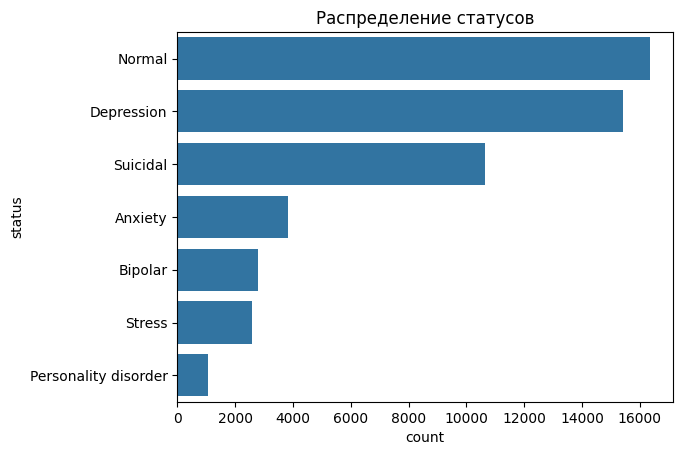

In [179]:
sns.barplot(data['status'].value_counts(), orient='h')
plt.title('Распределение статусов');

Наблюдаем сильный дизбаланс классов.

# Очистка данных

In [175]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

# удалим из списка стоп-слов некоторые слова, которые могут оказаться значимыми для оценки ментального состояния
english_stopwords = set(stopwords.words('english')) - set(['i', 'can', 'again', 'myself', 'my', 'should'])

In [176]:
def clean_text(text):
    """
    Полная очистка текста с сохранением эмоционально значимых элементов
    """

    if not isinstance(text, str):
        return ""
    
    # Удаление URL и HTML-тегов
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    
    # Обработка эмодзи (сохраняем их текстовое описание)
    text = emoji.demojize(text, delimiters=(" ", " "))
    
    # Удаление имен пользователей (@username) и хэштегов
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Удаление специальных символов (кроме пунктуации)
    text = re.sub(r'[^\w\s.,!?;:\']', '', text)

    # Удаление цифр
    text = re.sub(r'\d+', '', text)
    
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Лемматизация (сохраняя контекст)
    doc = nlp(text)
    words = [token.lemma_ for token in doc if token.lemma_.lower() not in english_stopwords]

    # words = text.split()
    # words = [lemmatizer.lemmatize(word) for word in words]
    
    # Удаление пунктуации (кроме эмоционально значимой: ! ? ...)
    translator = str.maketrans('', '', string.punctuation.replace('!', '').replace('?', ''))
    text = ' '.join(words).translate(translator)

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Сохранение многоточий как отдельного токена (индикатор депрессивных текстов)
    text = re.sub(r'\.{3,}', ' ... ', text)
    
    return text


def preprocess_dataframe(df, text_column='statement'):
    """
    Обработка всего датафрейма
    """
    
    df_clean = df.copy()
    df_clean['cleaned_text'] = df_clean[text_column].apply(clean_text)
    
    # Дополнительные метрики для анализа
    df_clean['text_length'] = df_clean['cleaned_text'].apply(lambda x: len(x.split()))
    df_clean['exclamation_count'] = df_clean[text_column].apply(lambda x: x.count('!'))
    df_clean['question_count'] = df_clean[text_column].apply(lambda x: x.count('?'))
    df_clean['ellipsis_count'] = df_clean[text_column].apply(lambda x: 1 if '...' in x else 0)
    
    return df_clean

In [177]:
# Очистка данных
data_clean = preprocess_dataframe(data)
data_clean.to_csv('data/mental_health_data_clean.csv', index=False)

data_clean.head()

,statement,status,cleaned_text,text_length,exclamation_count,question_count,ellipsis_count
0,oh my gosh,Anxiety,oh my gosh,3,0,0,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleep confused mind restless heart tune,7,0,0,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong back dear forward doubt stay restless re...,9,0,0,0
3,I've shifted my focus to something else but I'...,Anxiety,I shift my focus something else I still worried,9,0,0,0
4,"I'm restless and restless, it's been a month n...",Anxiety,I restless restless month boy mean ?,7,0,1,0


In [180]:
print("Пример очищенных текстов:")
data_clean[['statement', 'cleaned_text']].head()

Пример очищенных текстов:


,statement,cleaned_text
0,oh my gosh,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleep confused mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,I shift my focus something else I still worried
4,"I'm restless and restless, it's been a month n...",I restless restless month boy mean ?


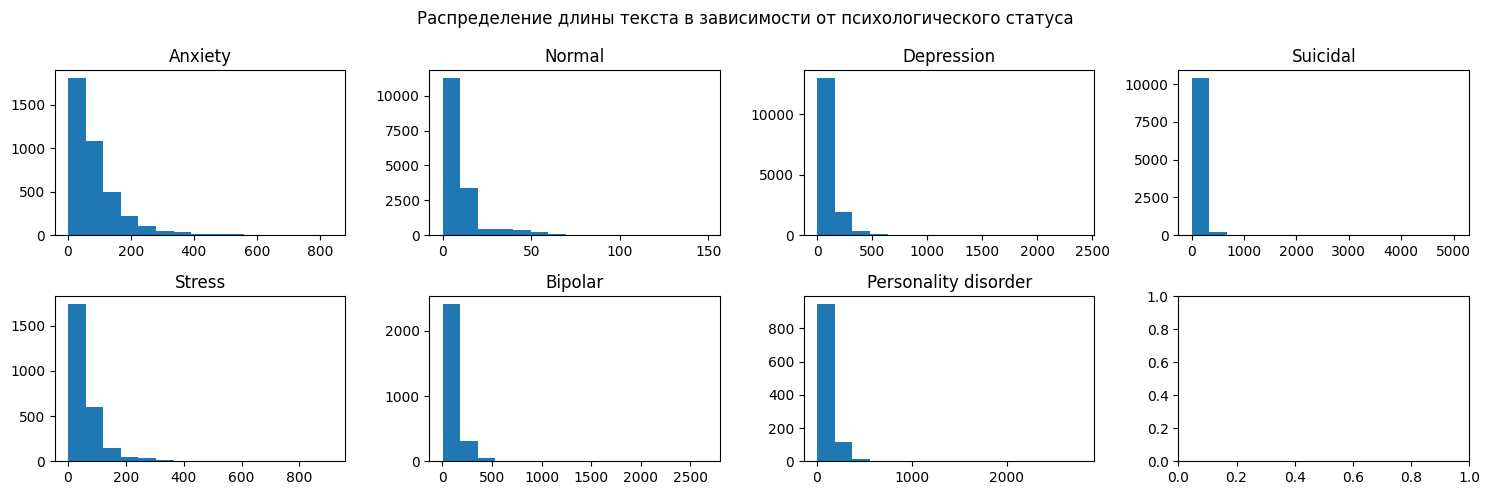

In [181]:
fig, axes = plt.subplots(2, 4, figsize=(15,5))
fig.suptitle('Распределение длины текста в зависимости от психологического статуса')
for ax, status in zip(axes.flatten(), data_clean['status'].unique()):
    ax.hist(data_clean.loc[data_clean['status'] == status, 'text_length'], bins=15)
    ax.set_title(status)
fig.tight_layout()

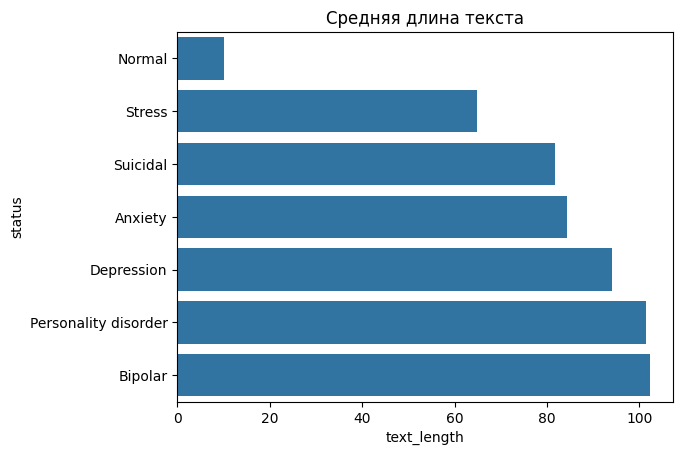

In [182]:
sns.barplot(data_clean.groupby('status')['text_length'].mean().sort_values(), orient='h')
plt.title('Средняя длина текста');

# Облака слов по статусам

In [58]:
def show_word_cloud(df, status: str):
    text = ' '.join(df.loc[df['status'] == status, 'cleaned_text'].to_list())

    # Сгенерировать облако слов  
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)  
    
    # Отобразить изображение  
    plt.figure(figsize=(10, 5))  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(status)  
    plt.axis('off')
    plt.show()

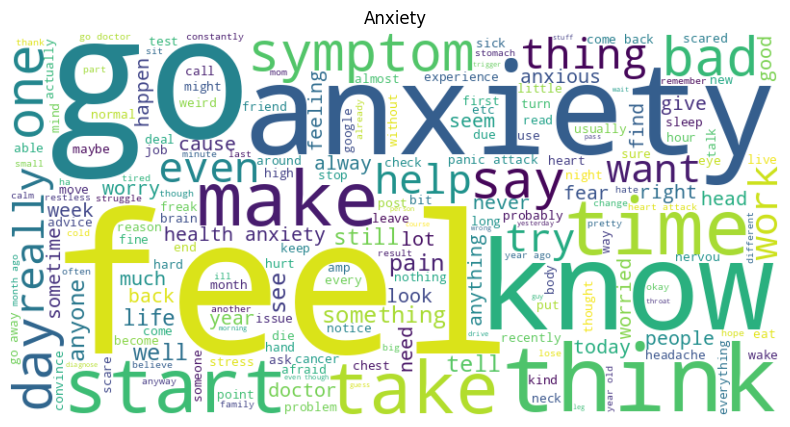

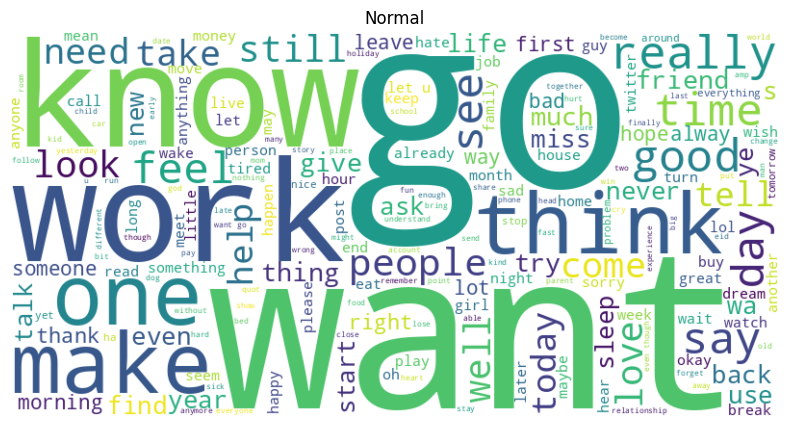

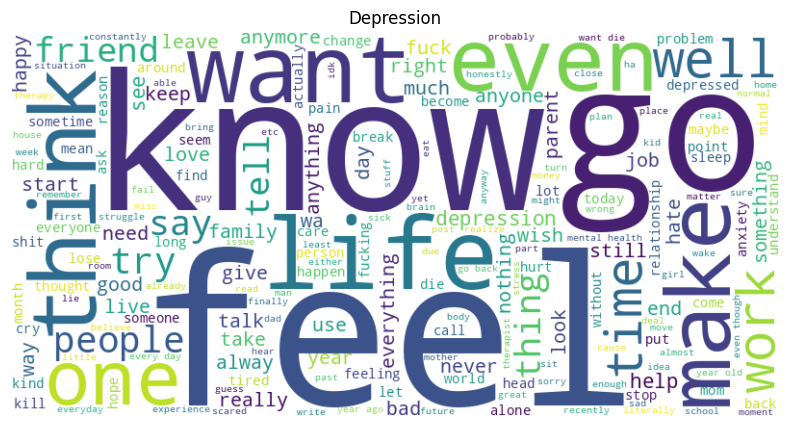

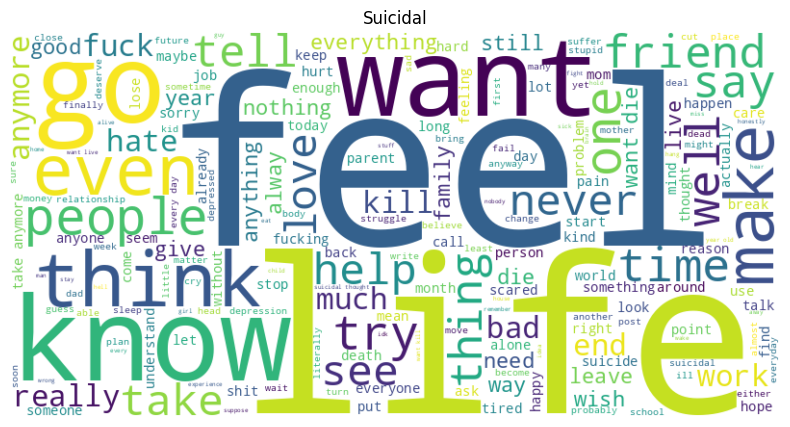

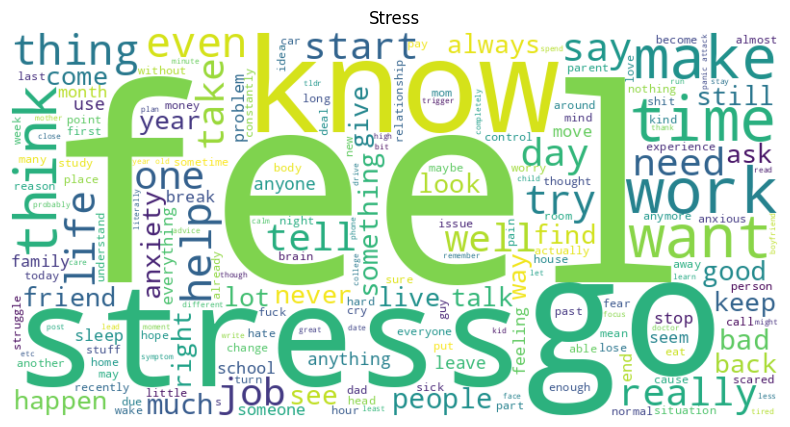

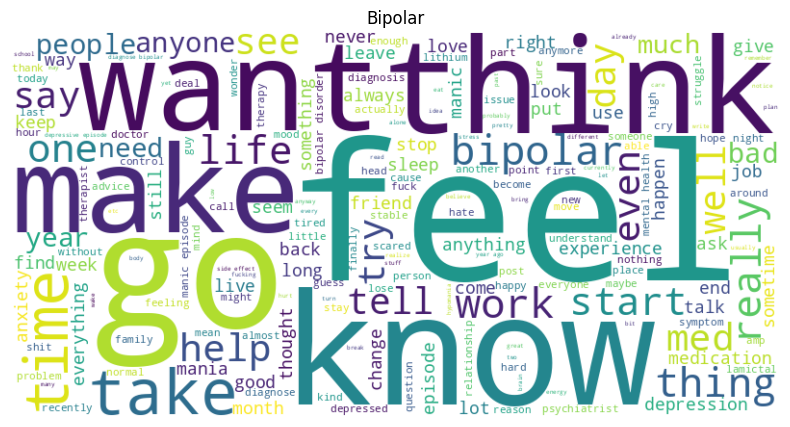

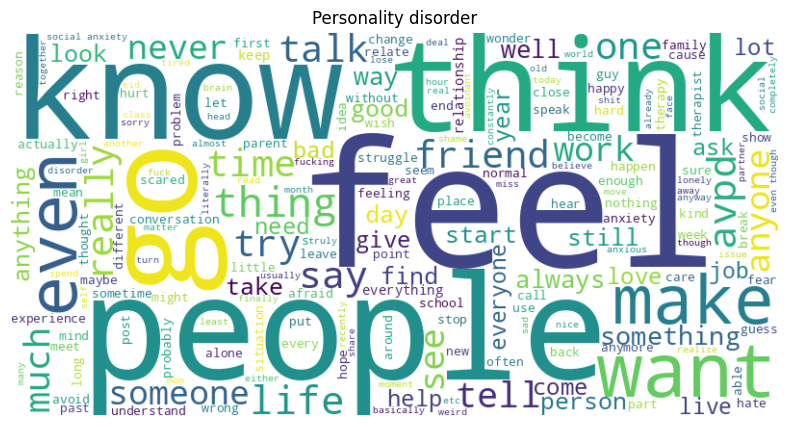

In [59]:
data_clean = pd.read_csv('data/mental_health_data_clean.csv')
for status in data_clean['status'].unique():
    show_word_cloud(data_clean, status)

# Извлечение лингвистических признаков

NOUN - существительное

VERB - глагол

PRON - местоимение

ADJ - прилагательное

In [184]:
nlp = spacy.load("en_core_web_sm")

In [185]:
def calculate_pos_percentages(text):
    """
    Вычисляет процент глаголов, существительных, местоимений 'I' и прилагательных в тексте.
    Возвращает словарь с процентами.
    """

    doc = nlp(text)
    
    # Считаем части речи
    pos_counts = Counter(token.pos_ for token in doc if not token.is_punct and not token.is_space)
    
    total_words = sum(pos_counts.values())
    
    if total_words == 0:
        return {
            'verb_percent': 0,
            'noun_percent': 0,
            'pron_percent': 0,
            'adj_percent': 0
        }
    
    # Вычисляем проценты
    adj_percent = (pos_counts.get('ADJ', 0) / total_words) * 100
    pron_percent = (pos_counts.get('PRON', 0) / total_words) * 100
    verb_percent = (pos_counts.get('VERB', 0) / total_words) * 100
    noun_percent = (pos_counts.get('NOUN', 0) / total_words) * 100
    
    return {
        'verb_percent': round(verb_percent, 2),
        'noun_percent': round(noun_percent, 2),
        'pron_percent': round(pron_percent, 2),
        'adj_percent': round(adj_percent, 2)
    }

In [186]:
parts_percents = pd.DataFrame(data_clean['cleaned_text'].map(calculate_pos_percentages).to_list())
data_expanded = pd.concat([data_clean, parts_percents], axis=1)

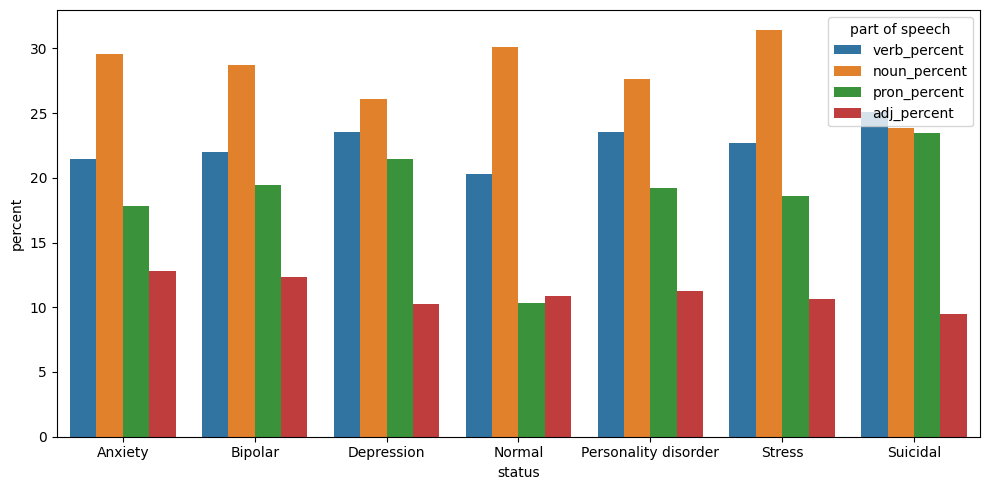

In [187]:
parts_percents_per_status = data_expanded.groupby('status')[['verb_percent', 'noun_percent', 'pron_percent', 'adj_percent']].mean()
parts_percents_per_status = (parts_percents_per_status
                             .reset_index()
                             .melt(id_vars='status', var_name='part of speech', value_name='percent'))

plt.figure(figsize=(10, 5))
sns.barplot(parts_percents_per_status, x='status', y='percent', hue='part of speech')
plt.tight_layout()

Процент содержания разных частей речи в зависимости от статуса примерно одинаковый за исключением двух интересных наблюдений:

1. У людей со статусом "Normal" в текстах заметно ниже процент содержания местоимений "I"
2. У людей со статусом "Suicidal" в текстах заметно ниже процент содержания существительных

# Извлечение психологических признаков

In [188]:
from nrclex import NRCLex

def get_text_top_emotion(text):
    emotion = NRCLex(text)
    top_emotion, score = emotion.top_emotions[0]
    if score == 0:
        return 'neutral'
    return top_emotion

In [189]:
data_expanded['top_emotion'] = data_expanded['cleaned_text'].map(get_text_top_emotion)
data_expanded['at_risk'] = data_expanded['status'] != 'Normal'

In [198]:
data_expanded.to_csv('data/mental_health_data_expanded.csv', index=False)